In [1]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## 首先导入训练好的模型, 熟悉图像预测方法

In [2]:
class Net(torch.nn.Module):
    def __init__(self):
        # 输入形状: (batch, 3, 150, 150)
        super(Net, self).__init__()

        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # 输出: (batch, 32, 150, 150)
            torch.nn.BatchNorm2d(32),  # 增加 Batch Normalization 提高训练稳定性
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)  # 输出: (batch, 32, 75, 75)
        )

        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # 输出: (batch, 64, 75, 75)
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)  # 输出: (batch, 64, 37, 37)
        )

        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # 输出: (batch, 128, 37, 37)
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)  # 输出: (batch, 128, 18, 18)
        )
        self.conv4 = torch.nn.Sequential(
            torch.nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # 输出: (batch, 256, 18, 18)
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)  # 输出: (batch, 256, 9, 9)
        )

        self.fc = torch.nn.Sequential(
            torch.nn.Linear(256 * 9 * 9, 512),  # 全连接层, 输入: 256*9*9
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),  # 添加 Dropout 防止过拟合
            torch.nn.Linear(512, 2)  # 最后输出 2 个类别
        )

    def forward(self, x):
        batch_size = x.size(0)
        x = self.conv1(x)  # 第一卷积模块
        x = self.conv2(x)  # 第二卷积模块
        x = self.conv3(x)  # 第三卷积模块
        x = self.conv4(x)  # 第四卷积模块
        x = x.view(batch_size, -1)  # 展平为全连接层输入
        x = self.fc(x)  # 全连接层
        return x  # 输出形状: (batch, 2)

model = Net().to(device)
model_path = '../models/2_Cat_Dog_Image_Classification/model_weights.pth'
# 加载模型参数
model.load_state_dict(torch.load(model_path))
# 将模型设置为评估模式
model.eval()

C:\Users\PC\AppData\Local\Temp\ipykernel_25204\3484827019.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Net(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(

In [3]:
# 图像预处理  与模型训练数据处理匹配
def image_transform(image):
    transform = transforms.Compose([
        transforms.RandomResizedCrop(150, scale=(0.8, 1.0)),  # 把图片的每一个channel随机裁剪成 150x150, 裁剪比例范围为 80% - 100%
        transforms.ToTensor()
    ])
    return transform(image)

# 预测函数
def predict_image(image_path, model, classes=['Cat', 'Dog']):
    image = Image.open(image_path)
    image = image_transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output.data, 1)
    return classes[predicted.item()]

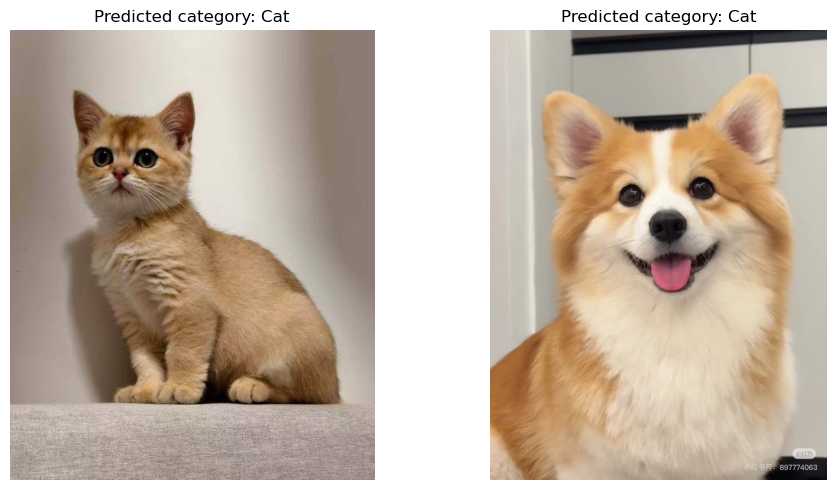

In [4]:
#展示图片及它们对应的预测标签

cat_path = './data/cat.jpg'
dog_path = './data/dog.jpg'

# 显示图像及预测结果
plt.figure(figsize=(10, 5))

# 猫图像
plt.subplot(1, 2, 1)
cat_predicted = predict_image(cat_path, model)
plt.imshow(Image.open(cat_path))
plt.title(f"Predicted category: {cat_predicted}")
plt.axis('off')

# 狗图像
plt.subplot(1, 2, 2)
dog_predicted = predict_image(dog_path, model)
plt.imshow(Image.open(dog_path))
plt.title(f"Predicted category: {dog_predicted}")
plt.axis('off')

# 显示结果
plt.tight_layout()
plt.show()

## 白盒攻击
基于PGD（Projected Gradient Descent）方法
- 提出者：Madry et al. (2017)
- 原理：FGSM的迭代版本，通过多次梯度下降步骤生成更强的对抗样本，并在每一步投影到扰动范围的约束内。
- 特点：攻击更强，鲁棒性更高，被认为是白盒攻击的“黄金标准”。

In [5]:
def pgd_attack(model, image_path, epsilon=8/255, alpha=1/255, iterations=20, classes=['Cat', 'Dog']):
    """
    使用PGD（Projected Gradient Descent）方法生成对抗样本
    
    参数:
    - model: 要攻击的模型
    - image_path: 原始图像路径
    - epsilon: 扰动大小的上限
    - alpha: 每次迭代的步长
    - iterations: 迭代次数
    - classes: 类别名称列表 (默认: ['Cat', 'Dog'])
    
    返回:
    - PIL Image格式的对抗样本图像
    """
    # model.eval()  # 设置为评估模式
    
    # 反归一化变换 - 将归一化的图像转换回原始图像范围
    inverse_normalize = transforms.Compose([
        transforms.Normalize(
            mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
            std=[1/0.229, 1/0.224, 1/0.225]
        )
    ])
    
    # 加载和预处理图像
    original_image = Image.open(image_path).convert('RGB')
    
    # 保存原始图像大小，以便后续恢复
    original_size = original_image.size
    
    # 转换图像为tensor
    img_tensor = image_transform(original_image).unsqueeze(0).to(device)
    
    # 获取原始图像的预测标签
    with torch.no_grad():
        output = model(img_tensor)
        _, original_pred = torch.max(output.data, 1)
    original_label = original_pred.item()
    target_label = 1 - original_label  # 假设只有两个类别，取反作为目标
    
    # 创建PGD对抗样本
    perturbed_image = img_tensor.clone().detach().requires_grad_(True)
    
    for i in range(iterations):
        # 前向传播
        output = model(perturbed_image)
        # 计算损失（PGD攻击中使用梯度上升来调整输入图像，所以是要最大化loss）
        loss = torch.nn.functional.cross_entropy(output, torch.tensor([target_label]).to(device))
        
        # 反向传播
        model.zero_grad()
        if perturbed_image.grad is not None:
            perturbed_image.grad.data.zero_()
        loss.backward()
        
        # 添加扰动
        adv_images = perturbed_image + alpha * perturbed_image.grad.sign()
        
        # 投影回epsilon球
        eta = torch.clamp(adv_images - img_tensor, min=-epsilon, max=epsilon)
        perturbed_image = torch.clamp(img_tensor + eta, min=0, max=1).detach_().requires_grad_(True)
    
    # 将对抗样本转换为PIL图像
    with torch.no_grad():
        restored_image = perturbed_image.squeeze(0)
        # 将tensor转换为PIL Image
        adv_image = transforms.ToPILImage()(restored_image.cpu())
        # 将图像调整回原始大小
        adv_image = adv_image.resize(original_size)
    
    return adv_image

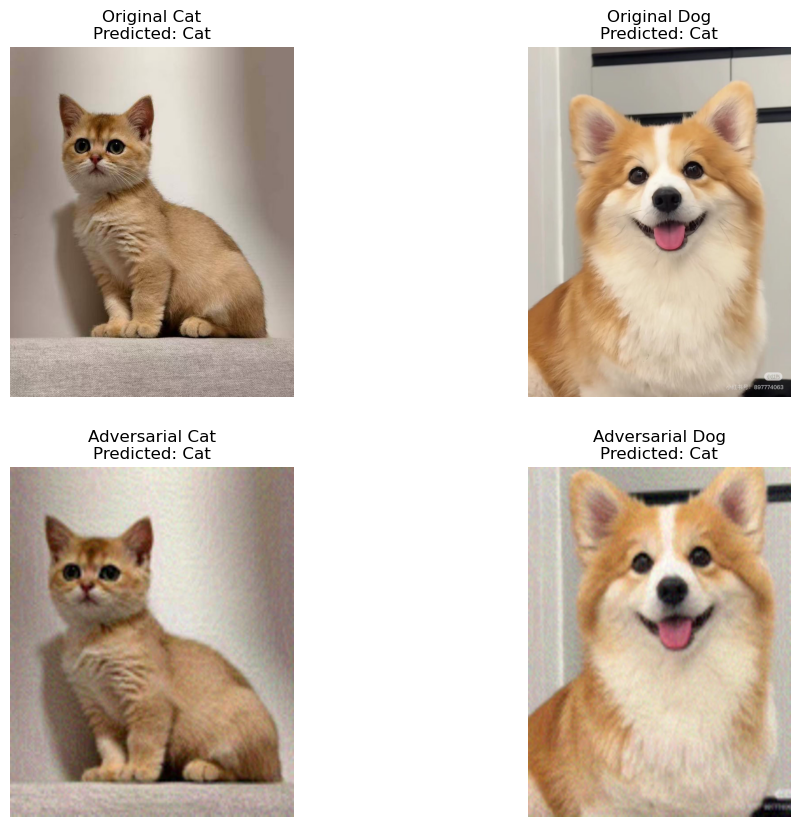

In [6]:
# 执行PGD攻击并保存对抗样本
cat_path = './data/cat.jpg'
dog_path = './data/dog.jpg'

# 生成对抗样本
attack_cat_image = pgd_attack(model, cat_path)
attack_dog_image = pgd_attack(model, dog_path)

# 保存对抗样本
attack_cat_path = './data/attack_cat.jpg'
attack_dog_path = './data/attack_dog.jpg'

attack_cat_image.save(attack_cat_path)
attack_dog_image.save(attack_dog_path)

# 显示图像及预测结果
plt.figure(figsize=(12, 10))

# 原始猫图像
plt.subplot(2, 2, 1)
cat_predicted = predict_image(cat_path, model)
plt.imshow(Image.open(cat_path))
plt.title(f"Original Cat\nPredicted: {cat_predicted}", fontsize=12)
plt.axis('off')

# 原始狗图像
plt.subplot(2, 2, 2)
dog_predicted = predict_image(dog_path, model)
plt.imshow(Image.open(dog_path))
plt.title(f"Original Dog\nPredicted: {dog_predicted}", fontsize=12)
plt.axis('off')

# 攻击后的猫图像
plt.subplot(2, 2, 3)
attack_cat_predicted = predict_image(attack_cat_path, model)
plt.imshow(Image.open(attack_cat_path))
plt.title(f"Adversarial Cat\nPredicted: {attack_cat_predicted}", fontsize=12)
plt.axis('off')

# 攻击后的狗图像
plt.subplot(2, 2, 4)
attack_dog_predicted = predict_image(attack_dog_path, model)
plt.imshow(Image.open(attack_dog_path))
plt.title(f"Adversarial Dog\nPredicted: {attack_dog_predicted}", fontsize=12)
plt.axis('off')

# 保存图像到本地
plt.savefig('./data/demo.jpg', dpi=300, bbox_inches='tight')